In [1]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import astropy.constants as const


environments = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                NLTE.NLTE_model.Environment(T_phot= 3350, photosphere_velocity= 0.220, line_velocity= 0.220, t_d=2.42),
                NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41),
                NLTE.NLTE_model.Environment(T_phot= 2600, photosphere_velocity= 0.155, line_velocity= 0.155, t_d=4.40),]

                
#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

 '51S' '53D' '53F' '53G' '53P' '53S' '61D' '61F' '61G' '61H' '61P' '61S'
 '63D' '63F' '63G' '63H' '63P' '63S']
Inserting ones for missing states
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6289bda830>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f628e10e1a0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f628951bbb0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f628951ad40>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f628951bc40>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f62899bc3a0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f62899bd270>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f628951b5e0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f62899be7a0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f62899bda50>]


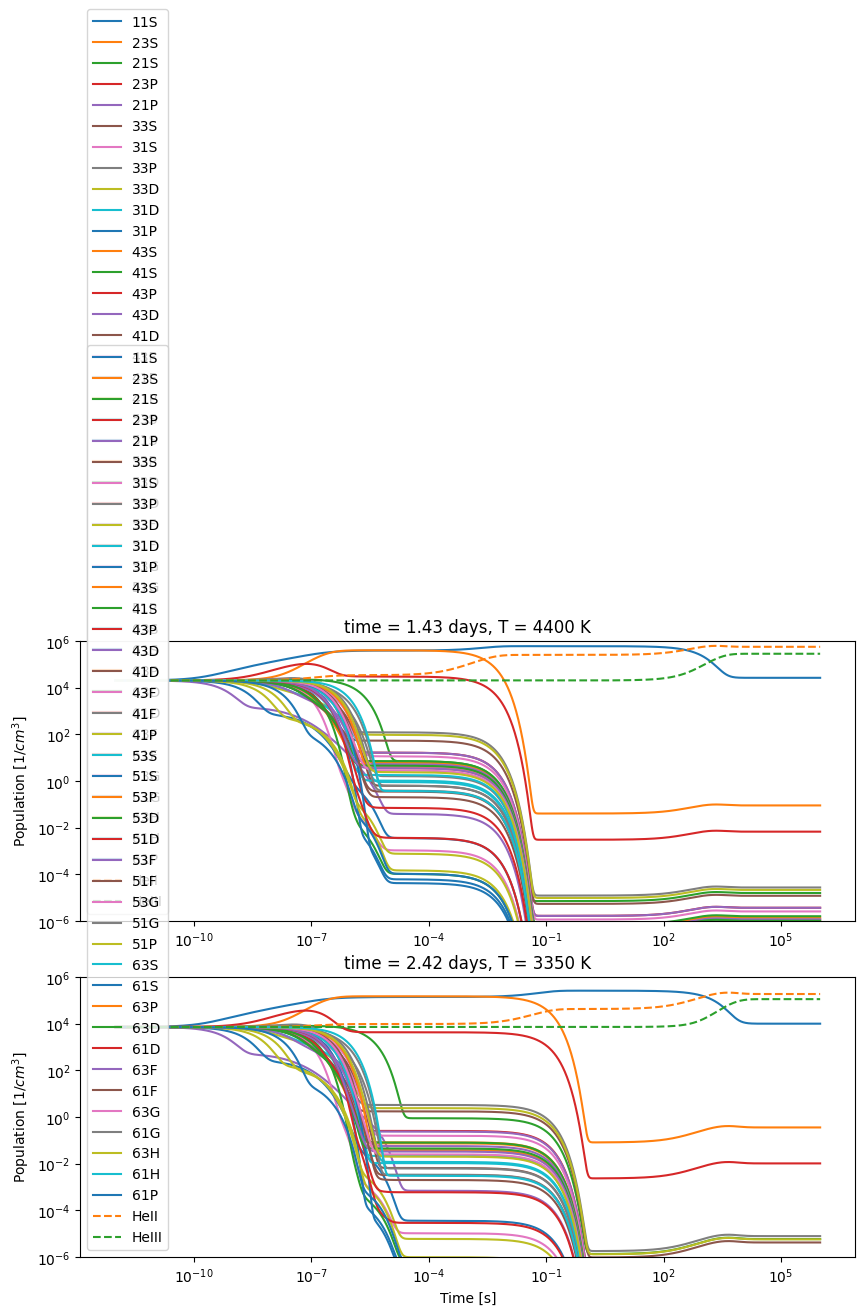

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 6)
for environment, ax in zip(environments, axes):
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    print(nlte_solver.processes)
    t, y = nlte_solver.solve(np.geomspace(1e-12,1000000, 1000))
    ax.plot(t, y.T[:, :-2], label = states.names);
    ax.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Population $[1/cm^3]$")
    ax.set_ylim(1e-6, 1e6)
    ax.legend(loc="lower left")
    ax.set_title(f"time = {environment.t_d} days, T = {environment.T_phot} K")
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)
ax.set_xlabel("Time [s]")
plt.savefig("plots/time_evolution.png", dpi=300, bbox_inches="tight")

Inserting ones for missing states
 '51S' '53D' '53F' '53G' '53P' '53S']
Inserting ones for missing states


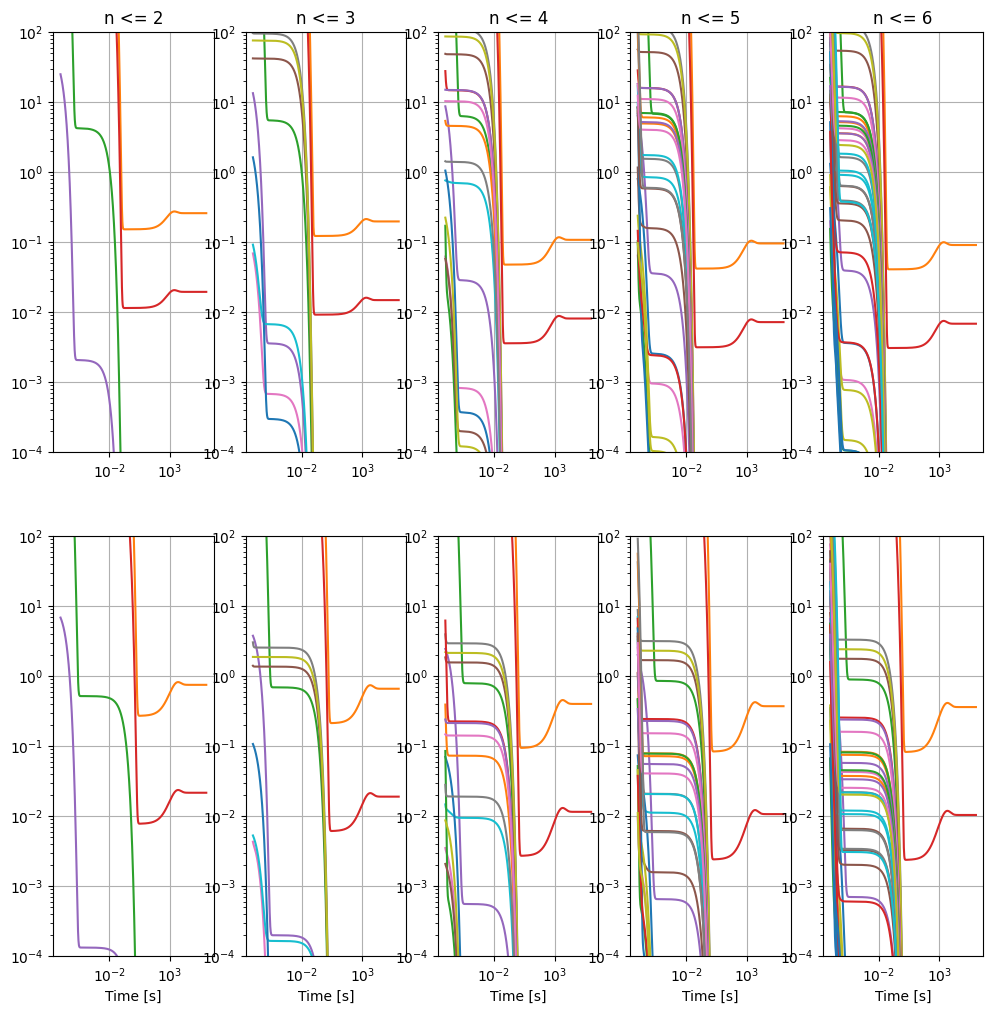

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12,12))
for ax_col, max_n in zip(axes.T, [2,3,4,5, 6]):
    states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= max_n)
    for environment, ax in zip(environments, ax_col):
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
        t, y = nlte_solver.solve(np.geomspace(1e-6,1000000, 1000))
        ax.plot(t, y.T[:, :-2], label = states.names);
        ax.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
        ax.set_yscale("log")
        ax.set_xscale("log")
        #ax.set_ylabel(r"Population $[1/cm^3]$")
        ax.set_ylim(1e-4, 1e2)
        #ax.set_title(f"time = {environment.t_d} days, T = {environment.T_phot} K")
        
        ax.grid()
        #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
        #    print(name, amount)
    ax_col[0].set_title(f"n <= {max_n}")
    ax.set_xlabel("Time [s]")
plt.savefig("plots/time_evolution.png", dpi=300, bbox_inches="tight")

Max fluxes out of ortho for t_d=1.43 and n<=1 (n_23S=0.7390618043187):
Photoionization          : 23S  -> HeII. Flux: 2.55e+01
Collision                : 23S  -> 21S . Flux: 8.90e+00
Collision                : 23S  -> 11S . Flux: 2.22e-01
Collision                : 23S  -> 21P . Flux: 6.06e-02
Radiative                : 23S  -> 21P . Flux: 1.37e-02
Max fluxes out of ortho for t_d=1.43 and n<=2 (n_23S=0.2590993096362488):
Photoionization          : 23P  -> HeII. Flux: 2.04e+01
Photoionization          : 23S  -> HeII. Flux: 8.94e+00
Collision                : 23S  -> 21S . Flux: 3.12e+00
Radiative                : 23P  -> 11S . Flux: 1.29e+00
Collision                : 23P  -> 21P . Flux: 5.22e-01
Max fluxes out of ortho for t_d=1.43 and n<=3 (n_23S=0.19747380510267187):
Photoionization          : 23P  -> HeII. Flux: 1.56e+01
Photoionization          : 23S  -> HeII. Flux: 6.81e+00
Photoionization          : 33P  -> HeII. Flux: 4.69e+00
Collision                : 23S  -> 21S . Flux: 2.38e

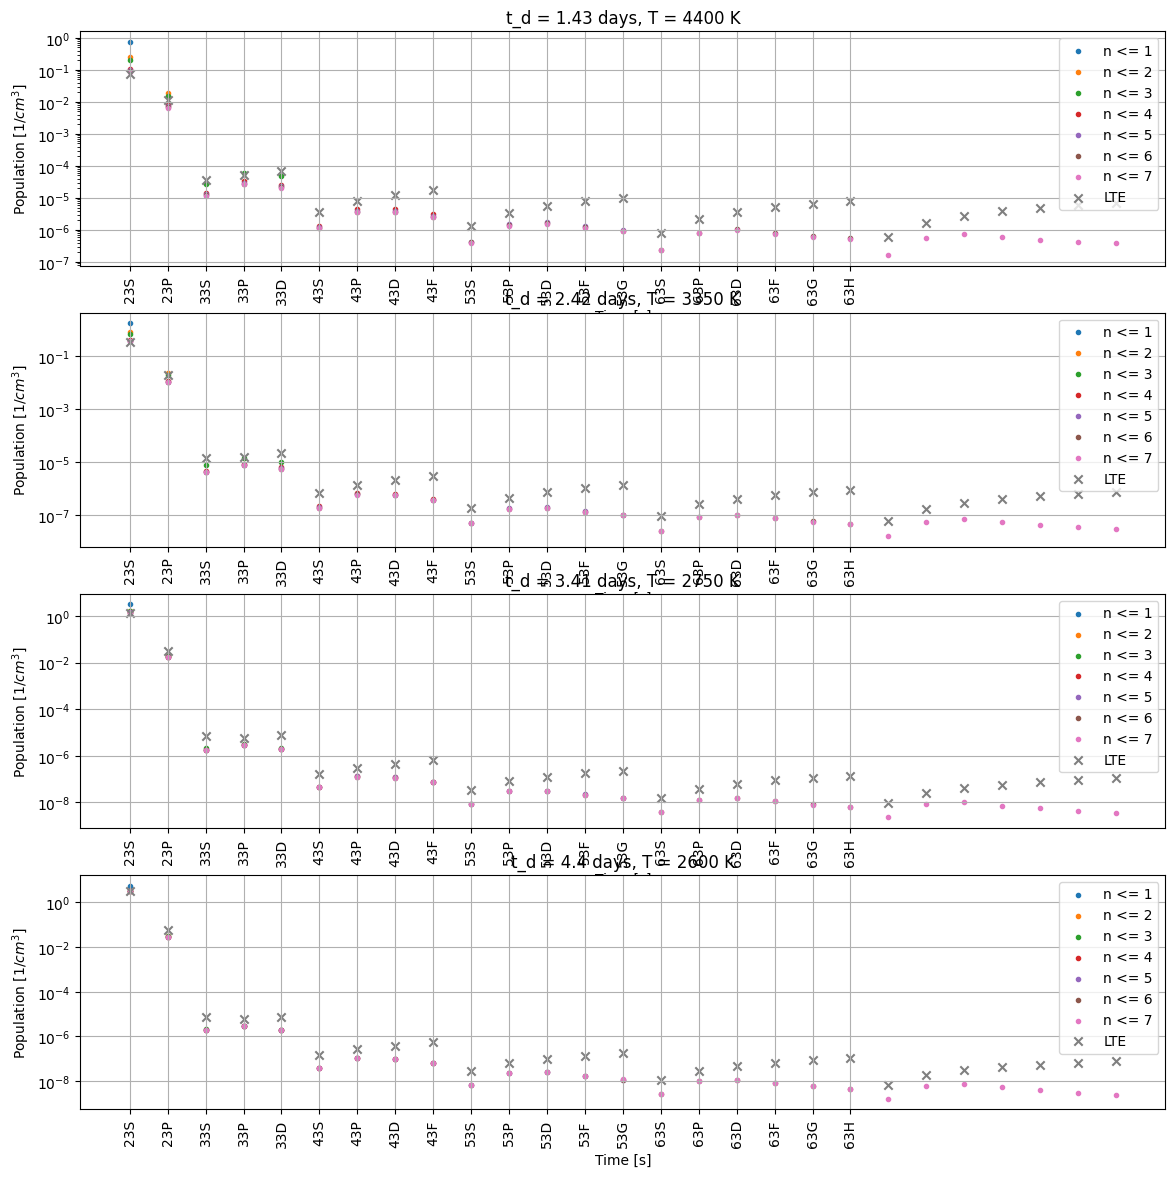

In [4]:
fig, axes = plt.subplots(4, 1, figsize=(14,14))
for environment, ax in zip(environments, axes):
    for max_n in [1,2,3,4,5,6,7]:
        if max_n == 1:
            states = NLTE.NLTE_model.States.read_states(filter = lambda table: (table.index != "23P") & (table["n"] <= 2))
        else:
            states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= max_n)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
        #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        y = nlte_solver.solve(1e6)[1][:,-1]
        ortho_filter = np.array([name[-2] == "3" for name in states.all_names])
        ax.scatter(np.array(states.all_names)[ortho_filter], y[ortho_filter], marker=".", label = f"n <= {max_n}");
        if max_n == 6:
            ax.set_xticks(np.arange(sum(ortho_filter)))
            ax.set_xticklabels(np.array(states.all_names)[ortho_filter], rotation=90)

        i = 0
        all_fluxes = [(process.get_transition_rate_matrix() * y[None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)

        print(f"Max fluxes out of ortho for t_d={environment.t_d} and n<={max_n} (n_23S={y[1]}):")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > 5:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
    
    bolzman = states.multiplicities * np.exp(-states.energies / (const.k_B * environment.T_phot * u.K))
    lte_pop = bolzman[ortho_filter[:-2]] / np.sum(bolzman[ortho_filter[:-2]]) * y[1]
    ax.scatter(np.array(states.all_names)[ortho_filter], lte_pop, marker="x", label = f"LTE");

    ax.set_yscale("log")
    ax.legend()
    ax.set_ylabel(r"Population $[1/cm^3]$")
    #ax.set_ylim(1e-2, 1e4)
    ax.set_title(f"t_d = {environment.t_d} days, T = {environment.T_phot} K")
    
    ax.grid()
    ax.set_xlabel("Time [s]")


In [5]:
A_coefficients = NLTE.NLTE_model.get_A_rates(tuple(states.all_names))

for T in zip([4900] + [x.T_phot for x in environments]):
    i23S = states.all_names.index("23S")
    i23P = states.all_names.index("23P")
    i33S = states.all_names.index("33S")
    i33D = states.all_names.index("33D")
    frac = states.multiplicities[i23P]/states.multiplicities[i23S] * np.exp(-(states.energies[i23P] - states.energies[i23S]) / (const.k_B * T * u.K))/2
    B_lower = A_coefficients[i23S,i23P] * states.multiplicities[i23P] / states.multiplicities[i23S]
    B_33S = A_coefficients[i23P,i33S] * states.multiplicities[i33S] / states.multiplicities[i23P]
    B_33D = A_coefficients[i23P,i33D] * states.multiplicities[i33D] / states.multiplicities[i23P]
    print("33S:", frac, B_33S/B_lower, 100 * frac *B_33S/B_lower)
    print("33D:", frac, B_33D/B_lower, 100 * frac *B_33D/B_lower)

33S: [0.09976346] 0.3029365700861394 [3.02219997]
33D: [0.09976346] 6.675150725804111 [66.5936117]
33S: [0.07331754] 0.3029365700861394 [2.2210564]
33D: [0.07331754] 6.675150725804111 [48.94056284]
33S: [0.02846649] 0.3029365700861394 [0.86235422]
33D: [0.02846649] 6.675150725804111 [19.00181413]
33S: [0.0119861] 0.3029365700861394 [0.36310277]
33D: [0.0119861] 6.675150725804111 [8.00090169]
33S: [0.00907138] 0.3029365700861394 [0.2748052]
33D: [0.00907138] 6.675150725804111 [6.05528118]


In [6]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 2)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
print(nlte_solver.solve(1e6)[1][:,-1])
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 3)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
print(nlte_solver.solve(1e6)[1][:,-1])

[3.35748285e+04 3.31048936e+00 2.63626322e-05 3.01216339e-02
 3.27387661e-09 2.13747822e+05 5.24631171e+04]
[3.35315682e+04 3.28190229e+00 2.61811298e-05 2.98617738e-02
 3.27462312e-09 2.07032238e-06 9.19999843e-12 2.98852343e-06
 2.02698883e-06 1.78834841e-10 1.48267010e-11 2.13782580e+05
 5.24716482e+04]


In [7]:
NLTE.NLTE_model.get_ionization_dict().keys()

dict_keys(['11S', '21S', '31S', '41S', '51S', '61S', '71S', '81S', '91S', '101S', '21P', '31P', '41P', '51P', '61P', '71P', '81P', '91P', '31D', '41D', '51D', '61D', '71D', '81D', '91D', '101D', '41F', '51F', '61F', '71F', '81F', '91F', '101F', '51G', '61G', '71G', '81G', '91G', '101G', '61H', '71H', '81H', '91H', '101H', '71I', '81I', '91I', '101I', '23S', '33S', '43S', '53S', '63S', '73S', '83S', '93S', '103S', '23P', '33P', '43P', '53P', '63P', '73P', '83P', '93P', '103P', '33D', '43D', '53D', '63D', '73D', '83D', '93D', '103D', '43F', '53F', '63F', '73F', '83F', '93F', '103F', '53G', '63G', '73G', '83G', '93G', '103G', '63H', '73H', '83H', '93H', '103H', '73I', '83I', '93I', '103I', '83K', '93K', '103K'])

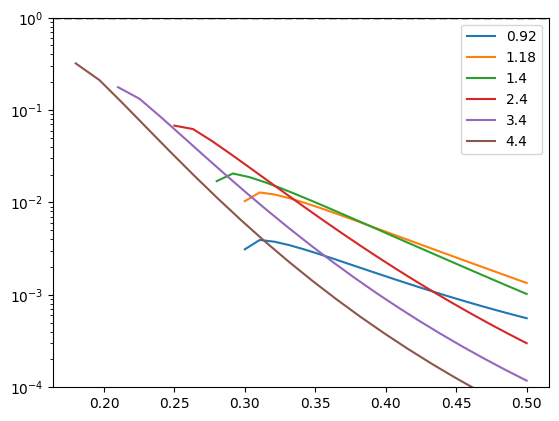

In [8]:

parameters = [{"T_phot": 5400, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 4400, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4200, "photosphere_velocity": 0.28, "t_d": 1.4},
              {"T_phot": 3300, "photosphere_velocity": 0.25, "t_d": 2.4},
              {"T_phot": 3000, "photosphere_velocity": 0.21, "t_d": 3.4},
              {"T_phot": 2900, "photosphere_velocity": 0.18, "t_d": 4.4},
              ]
density_table = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 20)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1), label = params["t_d"]);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    #plt.xscale("log")
    plt.ylim(1e-4, 1e0)
    plt.legend()
    plt.grid()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)

2.074109583271745
Max fluxes out of ortho:
Non-thermal electrons    : 23S  -> HeII. Flux: 2.82e+01
Radiative                : 23S  -> 11S . Flux: 3.39e+00
Non-thermal electrons    : 23P  -> HeII. Flux: 2.12e+00
Non-thermal electrons    : 33P  -> HeII. Flux: 8.65e-03
Non-thermal electrons    : 33D  -> HeII. Flux: 6.81e-03
Non-thermal electrons    : 33S  -> HeII. Flux: 3.79e-03
Non-thermal electrons    : 43P  -> HeII. Flux: 1.19e-03
2.009027605728935e-05
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 1.62e+01
Photoionization          : 23S  -> HeII. Flux: 7.10e+00
Photoionization          : 33P  -> HeII. Flux: 4.92e+00
Photoionization          : 33D  -> HeII. Flux: 2.23e+00
Photoionization          : 43P  -> HeII. Flux: 1.99e+00
Photoionization          : 43D  -> HeII. Flux: 1.45e+00
Photoionization          : 33S  -> HeII. Flux: 4.73e-01
0.0179338531143557
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 1.59e+00
Photoionization          :

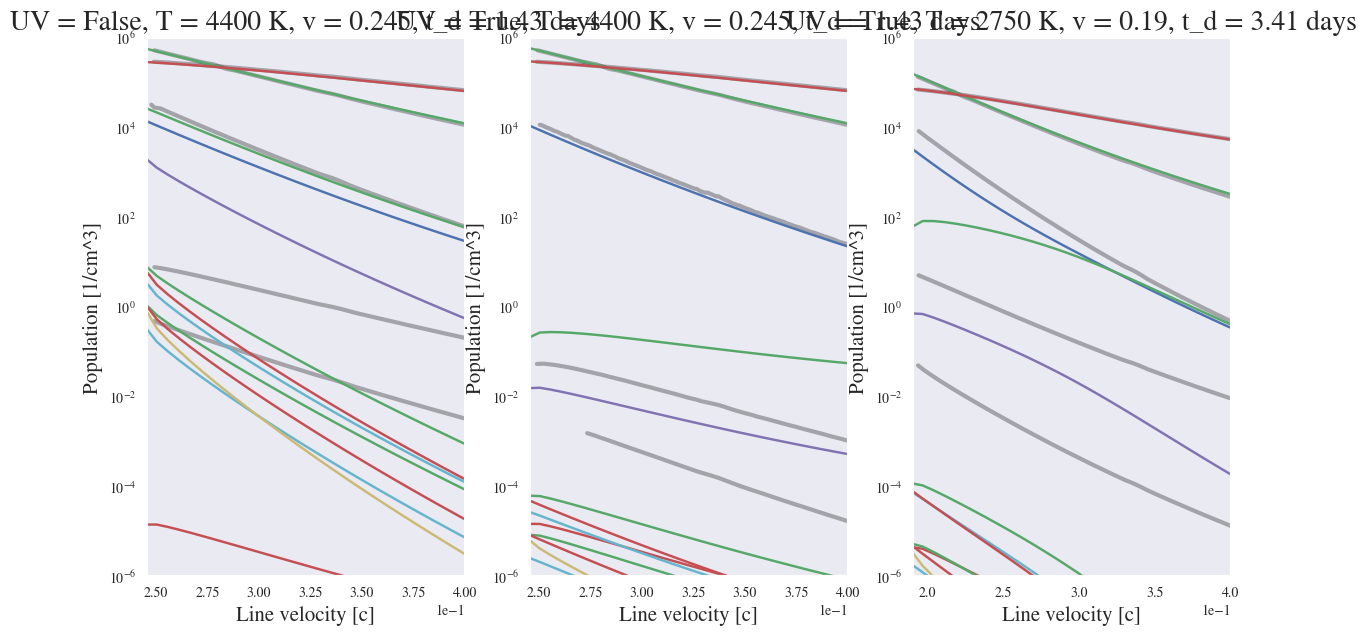

In [44]:
def plot_tarumi(ax, uv, T_phot, photosphere_velocity, t_d, states, print_exits = False):
    velocities = np.linspace(photosphere_velocity, 0.4, 30)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(T_phot= T_phot, photosphere_velocity= photosphere_velocity, line_velocity= v, t_d=t_d)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
        if not uv:
            nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        
        rad_process = nlte_solver.processes[1]
        coll_process = nlte_solver.processes[0]
        idx_of = lambda x: nlte_solver.states.all_names.index(x)
        for a in ["23S", "23P", "33S", "33P", "33D", "43S", "43P", "43D", "43F"]:
            for b in ["11S", "21S", "21P", "31S", "31P", "31D", "41S", "41P", "41D", "41F"]:
                if a == "23S" and b == "11S":
                    continue
                if a in nlte_solver.states.all_names and b in nlte_solver.states.all_names:
                    idx_a = idx_of(a)
                    idx_b = idx_of(b)
                    rad_process.A[idx_b, idx_a] = 0
                    rad_process.A[idx_a, idx_b] = 0
                    rad_process.A[idx_b, idx_a] = 0
                    rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
                    rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
                    rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
                    rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
                    if a == "23S":
                         continue
                    coll_process.collision_rates[idx_a, idx_b] = 0
                    coll_process.collision_rates[idx_b, idx_a] = 0
        #nlte_solver.processes[2].ionization_rates[2:] = 0
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
        

        if print_exits and v == velocities[0]:
            t, y = nlte_solver.solve(1e6)
            all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
            all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
            max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
            ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
            print_count = 7
            i = 0
            print(sum(y[ortho_filter,-1])/y[0,-1])
            print("Max fluxes out of ortho:")
            for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                    #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                    if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                            i += 1
                            if i > print_count:
                                    break
                            print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        
    for name, amount in zip(states.all_names, np.array(densities).T):
        ax.plot(velocities, amount, label=name)

fig, axes = plt.subplots(1, 3, figsize=(14,7))
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
tarumi_state_arr = [["11S", "23P", "23S", "He+", "He2+"], ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"], ["11S", "23P", "23S", "He+", "He2+"]]
for ax, uv, T_phot, photosphere_velocity, t_d, tarumi_states in zip(axes, [False, True, True], [4400, 4400, 2750], [0.245, 0.245, 0.190], [1.43, 1.43, 3.41], tarumi_state_arr):
    for name in tarumi_states:
        velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/{'Early' if t_d < 3 else 'Late'}{name}.csv", unpack=True, delimiter=";")
        ax.plot(velocity_23S, pops_23S, label=name, alpha=0.3, linewidth=3, color="k")
    plot_tarumi(ax, uv, T_phot, photosphere_velocity, t_d, states, print_exits = True)
    ax.set_title(f"UV = {uv}, T = {T_phot} K, v = {photosphere_velocity}, t_d = {t_d} days")
    ax.set_xlabel("Line velocity [c]")
    ax.set_ylabel("Population [1/cm^3]")
    ax.grid()
    ax.set_yscale("log")
    #ax.legend()
    ax.set_ylim(1e-6, 1e6)
    ax.set_xlim(photosphere_velocity, 0.4)

In [10]:
import itertools
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
print(environment.n_e)
for i, f in itertools.product(range(4), range(4)):
    print(f"{states.all_names[i]} -> {states.all_names[f]}: {nlte_solver.processes[0].get_transition_rate_matrix()[f, i]:.2e}")
i21S = nlte_solver.states.all_names.index("21S")
i31S = nlte_solver.states.all_names.index("31S")
nlte_solver.processes[0].get_transition_rate_matrix()[i31S, i21S]

107360475.19142391
11S -> 11S: 0.00e+00
11S -> 23S: 1.79e-23
11S -> 21S: 1.06e-24
11S -> 23P: 2.13e-25
23S -> 11S: 3.00e-01
23S -> 23S: 0.00e+00
23S -> 21S: 1.20e+01
23S -> 23P: 5.02e+00
21S -> 11S: 4.36e-01
21S -> 23S: 2.95e+02
21S -> 21S: 0.00e+00
21S -> 23P: 8.09e+01
23P -> 11S: 2.44e-02
23P -> 23S: 3.42e+01
23P -> 21S: 2.25e+01
23P -> 23P: 0.00e+00


0.019913475073096362

Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 2.50e+01
Collision                : 23P  -> 21P . Flux: 4.19e+00
Collision                : 23P  -> 21S . Flux: 3.52e+00
Collision                : 23S  -> 11S . Flux: 6.24e-01
Collision                : 23S  -> 21P . Flux: 1.70e-01
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 1.97e+01
Collision                : 23P  -> 21P . Flux: 2.54e+00
Collision                : 23P  -> 21S . Flux: 2.14e+00
Collision                : 23S  -> 11S . Flux: 4.97e-01
Collision                : 23S  -> 21P . Flux: 1.32e-01
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 1.50e+01
Collision                : 23P  -> 21P . Flux: 1.70e+00
Collision                : 23P  -> 21S . Flux: 1.45e+00
Collision                : 23S  -> 11S . Flux: 3.85e-01
Collision                : 23S  -> 21P . Flux: 1.00e-01
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 1.14e+01
Coll

FileNotFoundError: Tarumi_densities/Early['11S', '23P', '23S', 'He+', 'He2+'].csv not found.

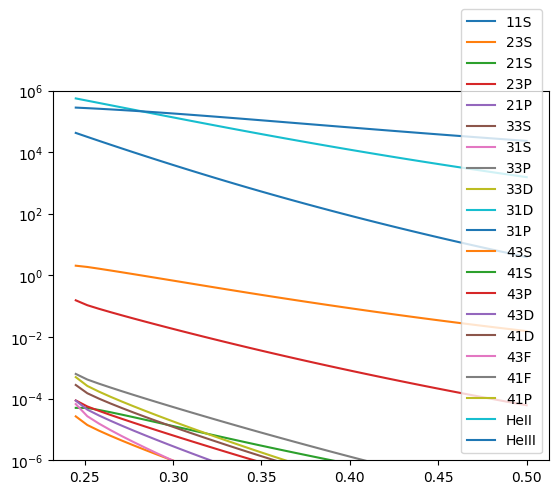

In [11]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    
    rad_process = nlte_solver.processes[1]
    idx_of = lambda x: nlte_solver.states.all_names.index(x)

    for a in ["23S", "23P", "33S", "33P", "33D", "43S", "43P", "43D", "43F"]:
        for b in ["11S", "21S", "21P", "31S", "31P", "31D", "41S", "41P", "41D", "41F"]:
            idx_a = idx_of(a)
            idx_b = idx_of(b)
            rad_process.A[idx_a, idx_b] = 0
            rad_process.A[idx_b, idx_a] = 0
            rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
            rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
            rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
            rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
    #nlte_solver.processes[2].ionization_rates[2:] = 0
    densities.append(nlte_solver.solve(1e7)[1][:, -1])
    

    t, y = nlte_solver.solve(1e6)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    print_count = 5
    i = 0
    print("Max fluxes out of ortho:")
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
            #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
            if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                    i += 1
                    if i > print_count:
                            break
                    print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = [["11S", "23P", "23S", "He+", "He2+"], ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"], ["11S", "23P", "23S", "He+", "He2+"]]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 1.40e+01
Photoionization          : 23S  -> HeII. Flux: 6.13e+00
Photoionization          : 33P  -> HeII. Flux: 4.18e+00
Radiative                : 43F  -> 31D . Flux: 3.04e+00
Photoionization          : 33D  -> HeII. Flux: 1.90e+00
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 1.02e+01
Photoionization          : 23S  -> HeII. Flux: 5.77e+00
Photoionization          : 33P  -> HeII. Flux: 3.02e+00
Radiative                : 43F  -> 31D . Flux: 1.74e+00
Photoionization          : 43P  -> HeII. Flux: 1.23e+00
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 7.49e+00
Photoionization          : 23S  -> HeII. Flux: 4.74e+00
Photoionization          : 33P  -> HeII. Flux: 2.20e+00
Radiative                : 43F  -> 31D . Flux: 1.13e+00
Photoionization          : 43P  -> HeII. Flux: 8.99e-01
Max fluxes out of ortho:
Photoionization          : 23P  -> HeII. Flux: 5.48e+00
Phot

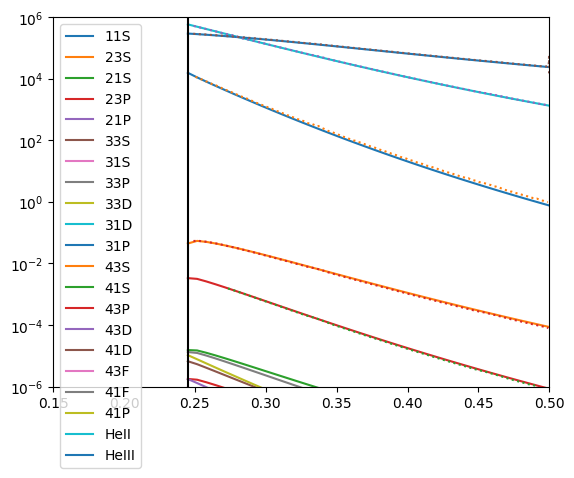

In [ ]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    
    rad_process = nlte_solver.processes[1]
    idx_of = lambda x: nlte_solver.states.all_names.index(x)

    for a,b in [("23P", "11S"), ("23P", "21S"), ("23P", "21P"), ("23P", "21S"), ("23S", "21S"), ("23S", "21P") ]:
        idx_a = idx_of(a)
        idx_b = idx_of(b)
        rad_process.A[idx_a, idx_b] = 0
        rad_process.A[idx_b, idx_a] = 0
        rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
        rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
        rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
        rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
    #nlte_solver.processes[2].ionization_rates[2:] = 0
    densities.append(nlte_solver.solve(1e7)[1][:, -1])
    

    t, y = nlte_solver.solve(1e6)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    print_count = 5
    i = 0
    print("Max fluxes out of ortho:")
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
            #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
            if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                    i += 1
                    if i > print_count:
                            break
                    print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")


    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=1, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 2.19e+00
Radiative                : 43F  -> 31D . Flux: 3.62e-01
Radiative                : 33D  -> 41F . Flux: 2.31e-01
Collision                : 23S  -> 11S . Flux: 1.94e-01
Collision                : 23P  -> 21S . Flux: 1.86e-01
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 3.35e-01
Collision                : 23S  -> 11S . Flux: 3.38e-02
Collision                : 23P  -> 21S . Flux: 1.22e-02
Collision                : 23P  -> 21P . Flux: 8.77e-03
Radiative                : 43F  -> 31D . Flux: 7.45e-03
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 4.95e-02
Collision                : 23S  -> 11S . Flux: 5.71e-03
Collision                : 23P  -> 21S . Flux: 1.15e-03
Collision                : 23P  -> 21P . Flux: 7.90e-04
Radiative                : 43F  -> 31D . Flux: 4.22e-04
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 8.42e-03
Coll

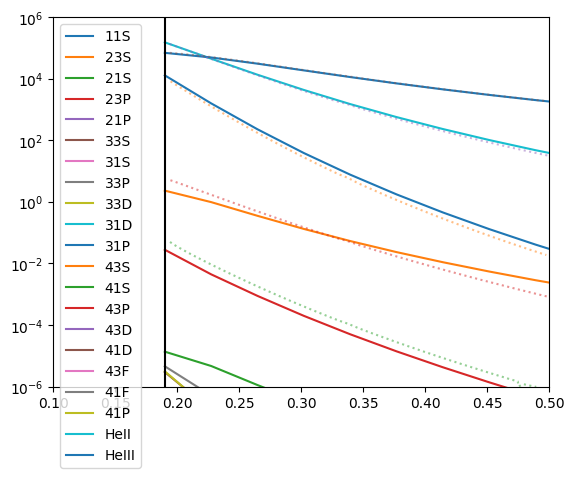

In [12]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
velocities = np.linspace(0.19, 0.9, 20)
densities = []
for v in velocities:
    #states = NLTE.NLTE_model.States().filter(["11S", "23S", "21S", "23P", "21P", "33S"])
    environment  = NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.19, line_velocity= v, t_d= 3.41)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    
    rad_process = nlte_solver.processes[1]
    idx_of = lambda x: nlte_solver.states.all_names.index(x)

    for a,b in [("23P", "11S"), ("23P", "21S"), ("23P", "21P"), ("23P", "21S"), ("23S", "21S"), ("23S", "21P") ]:
        idx_a = idx_of(a)
        idx_b = idx_of(b)
        rad_process.A[idx_a, idx_b] = 0
        rad_process.A[idx_b, idx_a] = 0
        rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
        rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
        rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
        rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
    densities.append(nlte_solver.solve(1e7)[1][:, -1])


    t, y = nlte_solver.solve(1e6)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    print_count = 5
    i = 0
    print("Max fluxes out of ortho:")
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
            #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
            if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                    i += 1
                    if i > print_count:
                            break
                    print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")



for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)

tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/late{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.1, 0.5)
plt.axvline(0.19, linestyle="-", color="black")

In [13]:

nlte_solver.processes

[<NLTE.NLTE_model.CollisionProcess object at 0x7f6283870670>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6283a2d600>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f62837f5e10>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6283a2c6a0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6283a2e8c0>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6283a2fd30>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6283a2cfd0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6283a2e170>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6283a2efb0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6283a2d0f0>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6283a2c7f0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6283a2d960>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6286fb25c0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6283a2f850>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6283a2fe20>]
[<NLTE.NLTE_mode

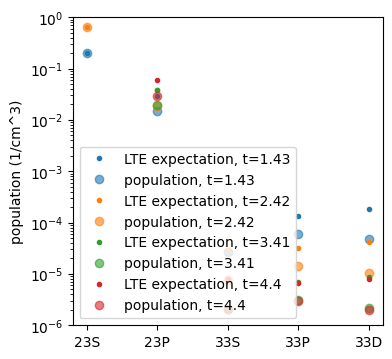

In [14]:

fig, ax1 = plt.subplots(1,1, figsize=(4,4))
for i, environment in enumerate(environments):
    nlte_solver = NLTE.NLTE_model.NLTESolver( environment)
    nlte_solver.processes = nlte_solver.processes
    t, y = nlte_solver.solve(1e6)
    print(nlte_solver.processes)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    names = np.array(nlte_solver.states.all_names)[ortho_filter]
    ax1_left  = ax1
    p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * nlte_solver.environment.T_electrons*u.K))
    p_i = p_i * y[1, -1] / p_i[1]
    ax1_left.plot(names,  p_i[ortho_filter[:-2]], ".", alpha=1, label=f"LTE expectation, t={environment.t_d}", color=f"C{i}")
    ax1_left.semilogy(names, y[ortho_filter, -1], "o", alpha=0.6, label=f"population, t={environment.t_d}", color=f"C{i}")
    ax1_left.legend(loc="lower left")
    ax1_left.set_ylim(1e-6, 1e0)
    ax1_left.set_ylabel("population (1/cm^3)")
plt.savefig("plots/ortho_population.png", dpi=300, bbox_inches="tight")


Max flux:
Radiative                : 23P  -> 23S . Flux: 8.49e+04
Radiative                : 23S  -> 23P . Flux: 8.49e+04
Radiative                : 23P  -> 33D . Flux: 3.19e+03
Radiative                : 33D  -> 23P . Flux: 3.18e+03
Max fluxes out of ortho:
Radiative                : 43F  -> 31D . Flux: 9.63e+00
Photoionization          : 23P  -> HeII. Flux: 8.50e+00
Radiative                : 33D  -> 41F . Flux: 6.16e+00
Photoionization          : 23S  -> HeII. Flux: 3.72e+00
Photoionization          : 33P  -> HeII. Flux: 2.58e+00
Collision                : 23S  -> 21S . Flux: 1.30e+00
Photoionization          : 33D  -> HeII. Flux: 1.16e+00
Photoionization          : 43P  -> HeII. Flux: 1.04e+00
Photoionization          : 43D  -> HeII. Flux: 7.60e-01
Radiative                : 23P  -> 11S . Flux: 5.38e-01
Radiative                : 33D  -> 21P . Flux: 3.92e-01
Photoionization          : 33S  -> HeII. Flux: 2.48e-01
Collision                : 23P  -> 21P . Flux: 2.17e-01
Photoionizati

KeyError: '43S'

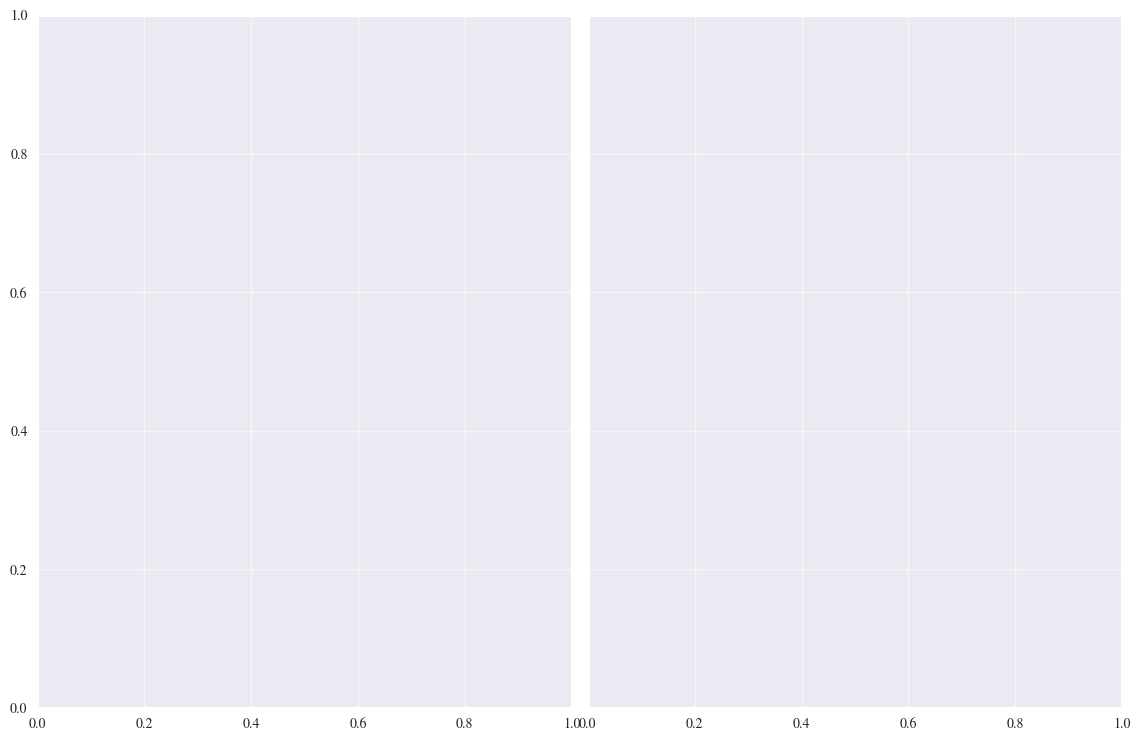

In [27]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(10,15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,9), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.01
max_rate = 1e2
max_width = 3

for environment, ax, title in zip(environments, axes, ["Early phase [1.4 days]", "Late phase [4.4 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states)
        nlte_solver.processes = nlte_solver.processes
        states = nlte_solver.states
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                        #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
                #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (2.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (2.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$1s{name[0]}{name[2].lower()}^{name[1]}{name[2]}$" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                #nx.draw(G, final_pos, ax=ax,
                #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                #        with_labels=True, labels=labels, 
                #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
                #        verticalalignment="bottom", 
                #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=1200 ,connectionstyle="arc3,rad=0.1",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1200)
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",
                                        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                ax.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax.set_ylim(14, 27)
        ax.plot([2.5, 2.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 5.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.001, 3.999])
        ax.set_xticklabels(["Singlet", "Triplet"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5], minor=True)

        ax.set_xticklabels(["S", "P", "D", "S", "P", "D"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        ax.set_title(title)
        ax.grid()

ax.legend(loc="lower right", title="Process types", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)

# make width scale
axes[0].scatter(np.linspace(0.6,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.6, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(max_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.09, r"Transition rate $\left[\frac{\text{#}}{\text{s}\cdot \text{cm}^3}\right]$", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.55, 0.03), 0.4, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0))
        
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes[0].set_ylabel("Energy [eV]")
axes[0].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "Ionization", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")
axes[1].spines.left.set_visible(False)
plt.savefig(f"plots/transition_rates.png", bbox_inches="tight", dpi=300)

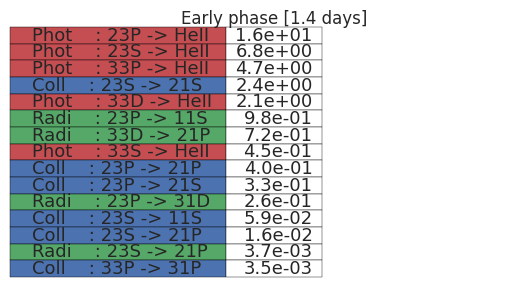

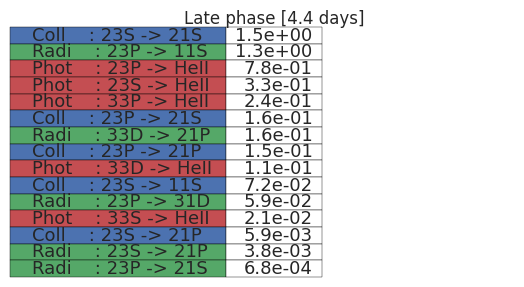

In [16]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')

print_count = 15
for environment, title in zip(environments, ["Early phase [1.4 days]", "Late phase [4.4 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        table = []
        labels = []
        colors = []
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        labels.append(f"{nlte_solver.processes[process_idx].name[:4]:8s}: {states.all_names[origin_idx]} -> {states.all_names[destination_idx]}")
                        table.append([f"{all_fluxes[process_idx, destination_idx, origin_idx]:1.1e}"])
                        colors.append(f"C{process_idx}")
        plt.figure(figsize=(6,4))
        plt.grid()
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.4, top=1)
        plt.axis("off")
        plt.title(title)
        the_table = plt.table(cellText=table, rowColours=colors, rowLabels=labels, loc='center', colWidths=[0.2, 0.2, 0.2, 0.2])
        plt.savefig(f"plots/transition_rates_{title}.png", bbox_inches="tight", dpi=300)

for process Collision the max flux into ortho states is 0.005355419963700179, which is from state 21S to state 23S
for process Radiative the max flux into ortho states is 7.088897510585606e-05, which is from state 31D to state 23P
for process Photoionization the max flux into ortho states is 0.0, which is from state 11S to state 23S
for process Recombination the max flux into ortho states is 34.84017789678022, which is from state HeII to state 23S
for process Non-thermal electrons the max flux into ortho states is 0.0, which is from state 11S to state 23S


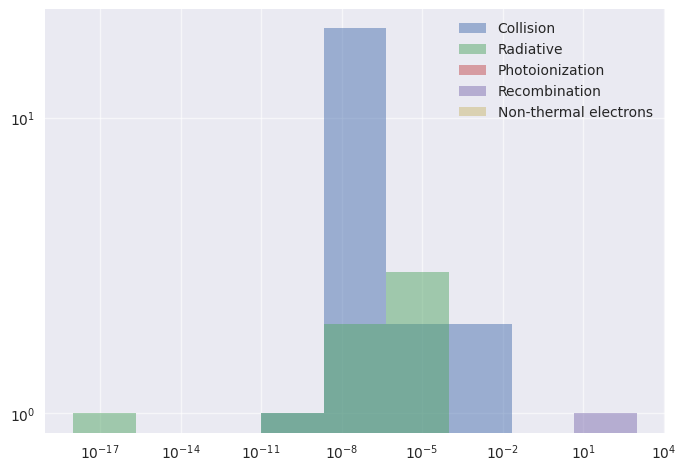

for process Collision the max flux out of ortho states is 2.3784046234176532, which is from state 23S to state 21S
for process Radiative the max flux out of ortho states is 0.9849969280947275, which is from state 23P to state 11S
for process Photoionization the max flux out of ortho states is 15.567108872210726, which is from state 23P to state HeII
for process Recombination the max flux out of ortho states is 0.0, which is from state 23S to state 11S
for process Non-thermal electrons the max flux out of ortho states is 0.00020917893742229175, which is from state 23S to state HeII


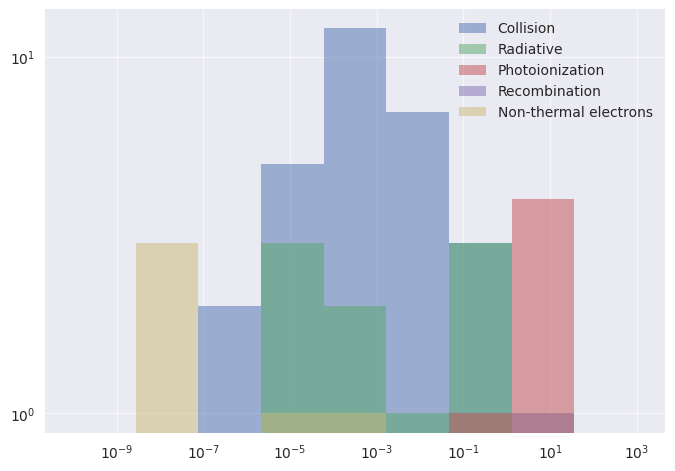

In [17]:
# make histogram of the flux sizes for each process
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
#nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
t, y = nlte_solver.solve(1000000)

ortho_states = np.array([name[1] == "3" for name in nlte_solver.states.all_names])
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    in_fluxes = fluxes[ortho_states, :][:, ~ortho_states]
    idx = np.unravel_index(np.argmax(in_fluxes), in_fluxes.shape)
    plt.hist(in_fluxes.flatten(), bins=np.geomspace(1e-18, 1000, 10), label=process.name, alpha=0.5, histtype="stepfilled")
    print(f"for process {process.name} the max flux into ortho states is {np.max(in_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[ortho_states][idx[0]]}")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    out_fluxes = fluxes[~ortho_states, :][:, ortho_states]
    idx = np.unravel_index(np.argmax(out_fluxes), out_fluxes.shape)
    plt.hist(out_fluxes.flatten(), bins=np.geomspace(1e-10, 1000, 10), label=process.name, alpha=0.5, histtype="stepfilled")
    print(f"for process {process.name} the max flux out of ortho states is {np.max(out_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[0]]}")
plt.legend()
plt.xscale("log")
plt.yscale("log")

/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


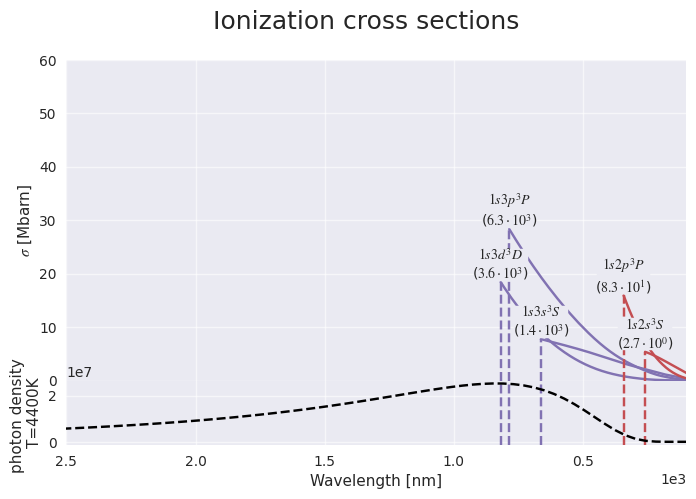

In [18]:
import NLTE.NLTE_model
ionization_rates = []
ionization_dict = NLTE.NLTE_model.get_ionization_dict()
spectrum = NLTE.NLTE_model.Environment().spectrum
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=True, height_ratios=[5, 1])
fancy_names = NLTE.NLTE_model.States().get_fancy_names()
format_latex_exponential = lambda x: f"${x:.1e}}}$".replace("e-0", "\cdot10^{-").replace("e+0", "\cdot10{^").replace("e+","\cdot10{^").replace("e-","\cdot10^{-")

for state in reversed(sorted(ionization_dict.keys())):
    if not (state[0] in "123" and state[1] == "3"):
        continue
    energies, crossection = ionization_dict[state]
    E = (energies * u.Ry).cgs
    nu = E.to(u.Hz, equivalencies=u.spectral()) 
    sigma = (crossection * u.Mbarn).cgs
    ionization_flux_article = u.sr * sigma
    x = E.to("nm", equivalencies=u.spectral()).value
    ax1.plot(x, crossection, label=state, color=f"C{state[0]}") 
    ax1.plot([x[0],x[0]], [0,crossection[0]], linestyle="--", color=f"C{state[0]}")
    ax2.axvline(x[[0]], linestyle="--", color=f"C{state[0]}")

    g = ("SPDFA".index(state[2])) *2 + 1
    lte_pop = g * np.exp(-(-E[0] + 0.3503019 * u.Ry)/(const.k_B*4400*u.K))
    ionization_flux_article = u.sr * sigma * (spectrum(nu)/E)
    #print(f"{state},\n R={np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value},\n LTE pop: {lte_pop.value}")
    ax1.text(x[[0]], crossection[0], f"{fancy_names[state]}\n({format_latex_exponential(np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value)})", 
             verticalalignment="bottom", horizontalalignment="center", fontsize=10,bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))


nm_range = np.linspace(100, 4000, 100) * u.nm
spectrum = BlackBody(4400 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)
#spectrum = BlackBody(4400 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
#ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)

ax1.set_ylim(0, 6e1)
ax1.set_xlim(2500, 100)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("Wavelength [nm]")
ax1.set_ylabel(r"$\sigma$ [Mbarn]")
ax2.set_ylabel("photon density \nT=4400K")
plt.suptitle("Ionization cross sections")
#ax1.yscale("log")
# plot spectrum on right axis
#plt.yscale("log")
#plt.ylim(0, 1e-1)
plt.savefig("plots/ionization_crosssections.png", dpi=300, bbox_inches="tight")

Max flux:
Radiative                : 23P  -> 23S . Flux: 8.49e+04
Radiative                : 23S  -> 23P . Flux: 8.49e+04
Radiative                : 23P  -> 33D . Flux: 3.19e+03
Radiative                : 33D  -> 23P . Flux: 3.18e+03
Max fluxes out of ortho:
Radiative                : 43F  -> 31D . Flux: 9.63e+00
Photoionization          : 23P  -> HeII. Flux: 8.50e+00
Radiative                : 33D  -> 41F . Flux: 6.16e+00
Photoionization          : 23S  -> HeII. Flux: 3.72e+00
Photoionization          : 33P  -> HeII. Flux: 2.58e+00
Collision                : 23S  -> 21S . Flux: 1.30e+00
Photoionization          : 33D  -> HeII. Flux: 1.16e+00
Photoionization          : 43P  -> HeII. Flux: 1.04e+00
Photoionization          : 43D  -> HeII. Flux: 7.60e-01
Radiative                : 23P  -> 11S . Flux: 5.38e-01
Radiative                : 33D  -> 21P . Flux: 3.92e-01
Photoionization          : 33S  -> HeII. Flux: 2.48e-01
Collision                : 23P  -> 21P . Flux: 2.17e-01
Photoionizati

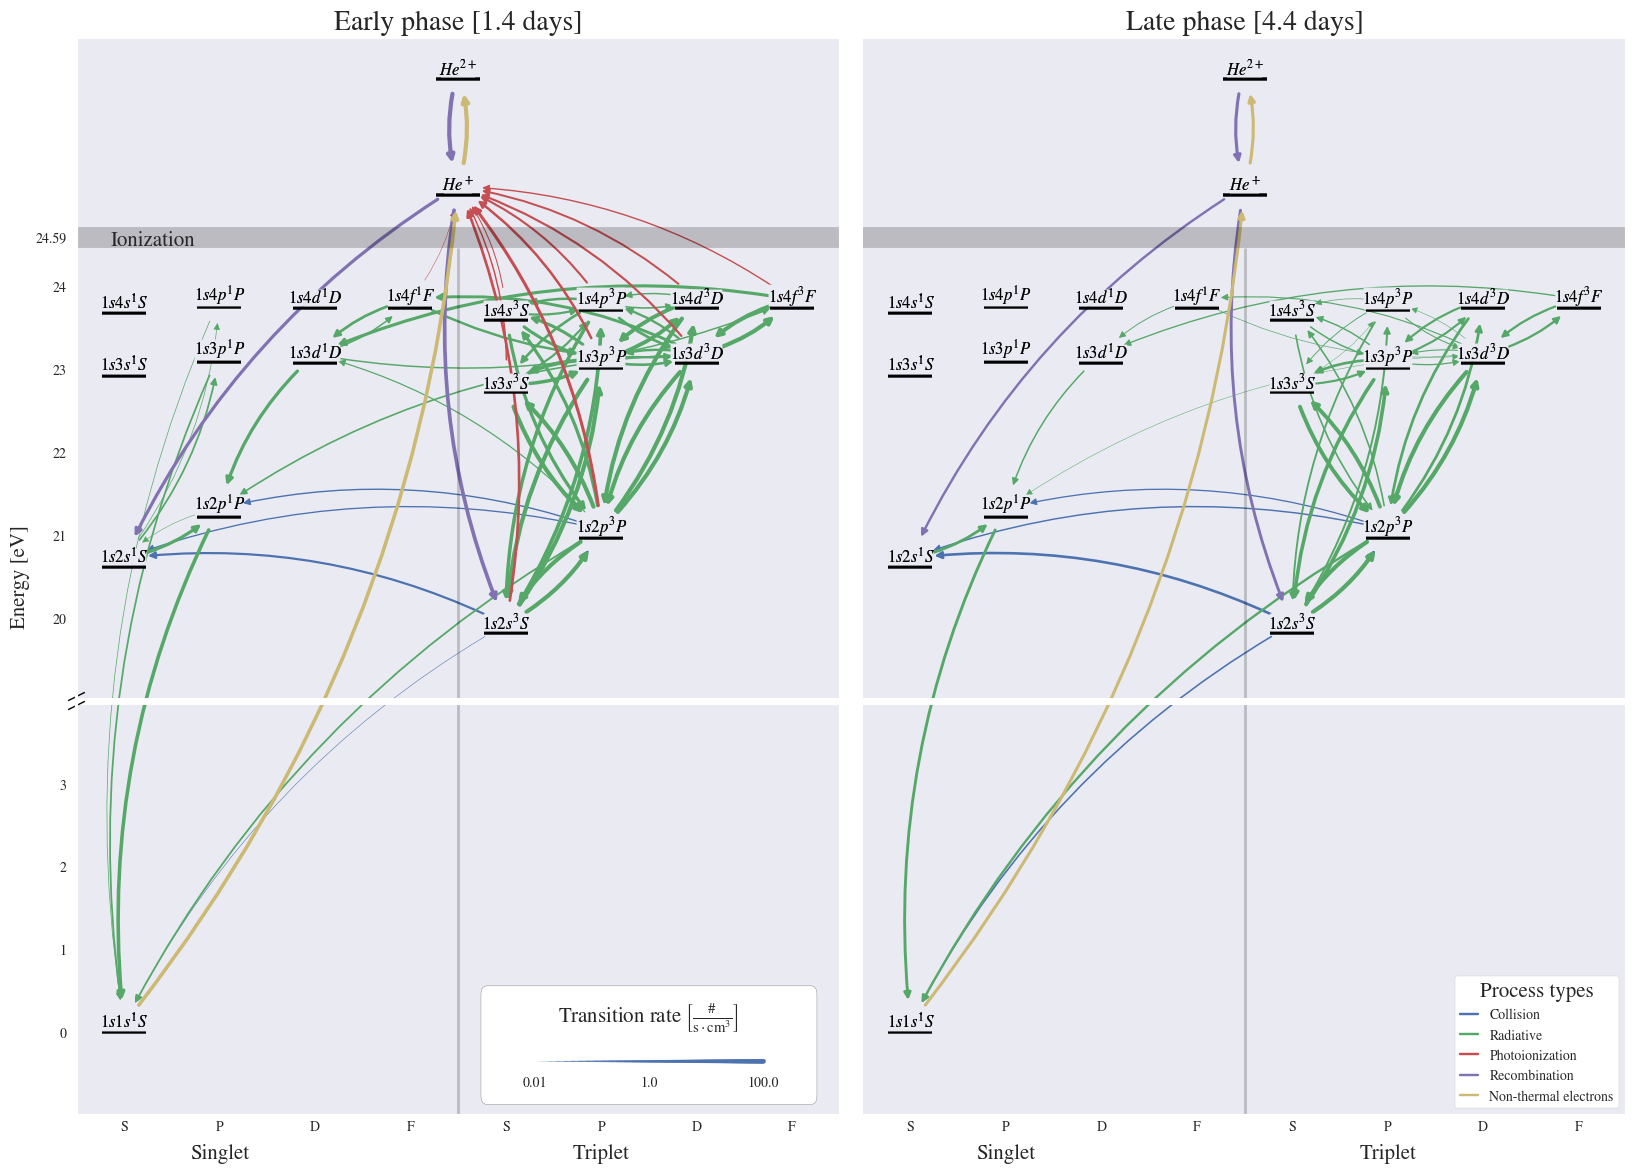

In [38]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(10,15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(20,14), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.01
max_rate = 1e2
max_width = 3

for environment, ax, title in zip([environments[0], environments[-1]], axes, ["Early phase [1.4 days]", "Late phase [4.4 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(lambda table: table["n"] <= 4)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                        #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
                #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                x_pos = {name: "SPDF".index(name[2]) + (4 if name[1] == "3" else 0) for name in states.names}
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (3.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (3.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$1s{name[0]}{name[2].lower()}^{name[1]}{name[2]}$" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                #nx.draw(G, final_pos, ax=ax,
                #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                #        with_labels=True, labels=labels, 
                #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
                #        verticalalignment="bottom", 
                #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=1200 ,connectionstyle="arc3,rad=0.15",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1000)
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",
                                        bbox=dict(facecolor=ax.get_facecolor()*np.array([1,1,1,0.5]), alpha=0.5, edgecolor = ax.get_facecolor()*np.array([1,1,1,0.5]), boxstyle='square,pad=-0.1'))
                ax.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax.set_ylim(14, 27)
        ax.plot([3.5, 3.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.001, 4.999])
        ax.set_xticklabels(["Singlet", "Triplet"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7], minor=True)

        ax.set_xticklabels(["S", "P", "D", "F", "S", "P", "D", "F"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        ax.set_title(title)
        ax.grid()

ax.legend(loc="lower right", title="Process types", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)

# make width scale
axes[0].scatter(np.linspace(0.6,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.6, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(max_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.09, r"Transition rate $\left[\frac{\text{#}}{\text{s}\cdot \text{cm}^3}\right]$", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.55, 0.03), 0.4, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0))
        
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes[0].set_ylabel("Energy [eV]")
axes[0].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "Ionization", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")
axes[1].spines.left.set_visible(False)
plt.savefig(f"plots/transition_rates.png", bbox_inches="tight", dpi=300)

In [25]:
final_pos

{'11S': (0, 15),
 '23S': (4, 19.819614525),
 '21S': (0, 20.615774823),
 '23P': (5, 20.96408688908),
 '21P': (1, 21.2180227112),
 '33S': (4, 22.718466419),
 '31S': (0, 22.920317359),
 '33P': (5, 23.00707314571),
 '33D': (6, 23.07365070854),
 '31D': (2, 23.07407479777),
 '31P': (1, 23.0870185296),
 '43S': (4, 23.593958713),
 '41S': (0, 23.67357059),
 '43P': (5, 23.7078912279),
 '43D': (6, 23.7360901901),
 '41D': (2, 23.73633503536),
 '43F': (7, 23.737006806968),
 '41F': (3, 23.737009722091),
 '41P': (1, 23.7420700688),
 'HeII': (3.5, 25.1),
 'HeIII': (3.5, 26.5)}

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85],
 [Text(0, 0, '$1s2s^3S$'),
  Text(1, 0, '$1s2p^3P$'),
  Text(2, 0, '$1s3s^3S$'),
  Text(3, 0, '$1s3p^3P$'),
  Text(4, 0, '$1s3d^3D$'),
  Text(5, 0, '$1s4s^3S$'),
  Text(6, 0, '$1s4p^3P$'),
  Text(7, 0, '$1s4d^3D$'),
  Text(8, 0, '$1s4f^3F$'),
  Text(9, 0, '$1s5s^3S$'),
  Text(10, 0, '$1s5p^3P$'),
  Text(11, 0, '$1s5d^3D$'),
  Text(12, 0, '$1s5f^3F$'),
  Text(13, 0, '$1s5g^3G$'),
  Text(14, 0, '$1s6s^3S$'),
  Text(15, 0, '$1s6p^3P$'),
  Text(16, 0, '$1s6d^3D$'),
  Text(17, 0, '$1s6f^3F$'),

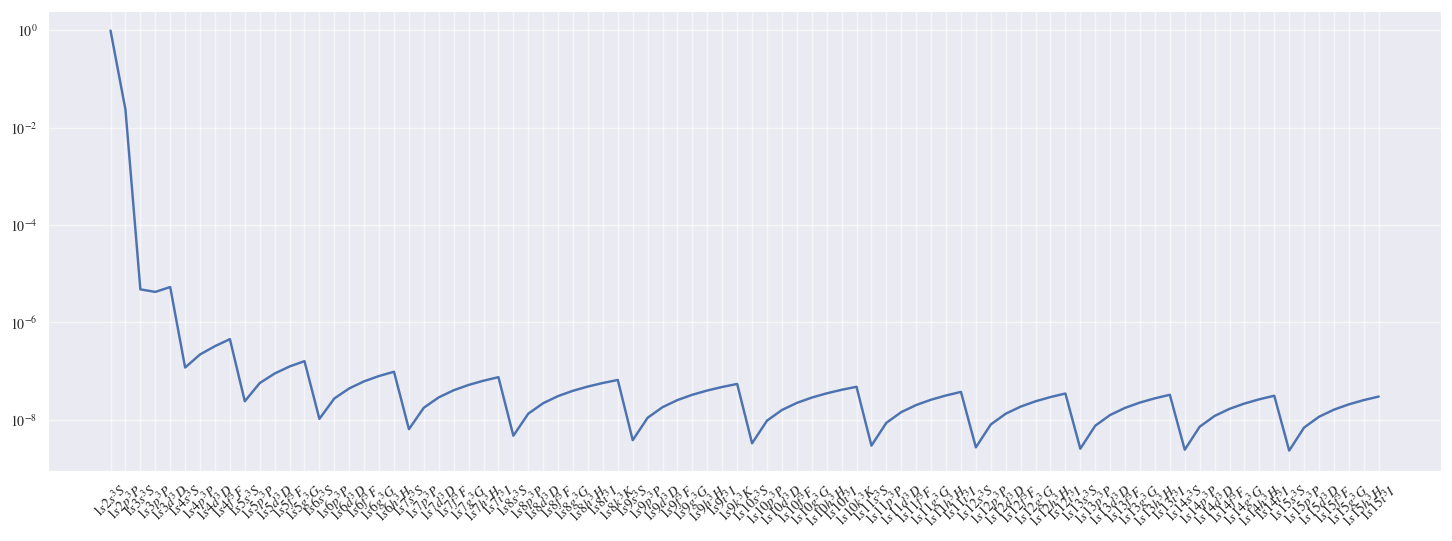

In [20]:
plt.figure(figsize=(18,6))
states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 15))
ortho_filter = np.array([x[-2] == "3" for x in states.names])
lvl = states.multiplicities * np.exp(-(states.energies)/(const.k_B*2750*u.K))
lvl = lvl[ortho_filter]
lvl = lvl / np.sum(lvl)
plt.semilogy([value for key, value in states.get_fancy_names().items() if key[-2] == "3" ], lvl)
#rotate labels
plt.xticks(rotation=45)


In [21]:
nist_table = NLTE.NLTE_model.get_A_table()
A_coefficients = np.zeros((len(names), len(names)))
for row, ((lower_name, upper_name), subtable) in enumerate(nist_table.groupby(["lower_name", "upper_name"])):
    if not (lower_name in names and upper_name in names):
        continue
    print(lower_name, len(subtable))
    weighted_A = np.average(subtable["A_rates"], weights=subtable["g_k"])
    #if lower in names and upper in names:
    A_coefficients[names.index(lower_name),names.index(upper_name)] = weighted_A
plt.imshow(np.log(A_coefficients))
plt.xticks(range(len(names)), names, rotation=45)
plt.yticks(range(len(names)), names)
plt.grid()

23P 6


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
is_ortho = lambda names: np.array([x[-2] == "3" for x in names])
is_low_enough = lambda names: np.array([int(x[:-2]) < 7 for x in names])
# take a weighted mean of the A rates according to g_k
grouped = nist_table.groupby(["lower_name", "upper_name"])
# Make a dataframe with columns lower_name, upper_name, weighed average A_rates and the unique line_ref
weighted_A = grouped.apply(lambda x: np.average(x["A_rates"], weights=x["g_k"]))
ref = grouped.first()["line_ref"]
weighted_A = pandas.DataFrame({"A_rates": weighted_A, "line_ref": ref}).reset_index()

exit_pathways = weighted_A[(is_ortho(weighted_A["lower_name"]) != is_ortho(weighted_A["upper_name"])) &
                           is_low_enough(weighted_A["lower_name"]) & is_low_enough(weighted_A["upper_name"])]
#weighted_A.reset_index()

exit_pathways.sort_values("A_rates", ascending=False).head(30)



,lower_name,upper_name,A_rates,line_ref
94,31D,43F,2.830551e+06,
148,33D,41F,2.427550e+06,
99,31D,53F,7.700722e+05,
151,33D,51F,6.608500e+05,
200,41D,53F,4.414300e+05,
271,43D,51F,3.782950e+05,
103,31D,63F,3.219175e+05,
154,33D,61F,2.764750e+05,
205,41D,63F,1.950192e+05,
275,43D,61F,1.673200e+05,


In [ ]:
import os
os.environ['XUVTOP'] = "chianti"
import ChiantiPy.core as ch
import astropy.units as u
import numpy as np
 
helium = ch.ion('he_1', temperature=4400, eDensity=1e10, radTemperature=4400, rStar=1, verbose=1)
ortho_levels = [lvl for spin, lvl in zip(helium.Elvlc["spin"], helium.Elvlc["lvl"]) if spin == 3]
labels = {lvl: f"{name}^{spin}" for lvl, name, spin in zip(helium.Elvlc["lvl"], helium.Elvlc["term"], helium.Elvlc["spin"])}
#np.array(helium.Elvlc)[ortho_levels]
[(gf, labels[lvl1], labels[lvl2]) for gf, lvl1, lvl2 in zip(helium.Wgfa["gf"], helium.Wgfa["lvl1"], helium.Wgfa["lvl2"]) if ((lvl1 in ortho_levels) != (lvl2 in ortho_levels))]

[(0.0, '1s2^1', '1s.2s^3'), (3.58e-08, '1s2^1', '1s.2p^3')]

In [ ]:
(1869.724002 * (u.cm**-1)).to("Å", equivalencies=u.spectral())

<Quantity 53483.82964172 Angstrom>

In [ ]:
f12 = 1
nu = (1869.723 * u.cm**-1).to(u.Hz, equivalencies=u.spectral())
g_frac = 1
A = 2*np.pi*(nu * const.e.to("C"))**2/(const.eps0*const.m_e*const.c**3) * f12
A.si

<Quantity 2331829.37128175 1 / s>

In [ ]:

T = 4400 * u.K
v = 1000 * u.m/u.s
(const.m_e * v**2 /(2*const.k_B * T)).si

<Quantity 7.49761336e-06>

In [ ]:
import scipy.integrate
import pandas
def parse_electron_ionization_params():
    table = pandas.read_csv("atomic data/electron_ionization.csv", skiprows=6, skipfooter=5, engine="python", sep="\s+", header=None, index_col="i", names=["i", "A_1", "A_2", "A_3", "A_4", "A_5", "A_6"])
    return table.T.to_dict("list")
sigma_params = parse_electron_ionization_params()
ion_threshold = {name:(x[0][0] * u.Ry).to(u.eV) for name,x in NLTE.NLTE_model.get_ionization_dict().items()}

T = 4400 * u.K
n_e = 2.8e7 * u.cm**-3
def get_sigma(statename, sigma_params, ion_threshold):
    A = sigma_params[statename] * u.cm**2
    I = ion_threshold[statename]
    exponents = np.arange(1,6)
    def sigma(E):
        parenthesis = 1-I/E
        return np.where(E > I, 1e-13 * u.eV**2/(I*E)*(A[0] * np.log(E/I) + sum([A[i] * parenthesis**i for i in exponents])), 0 * u.cm**2)
    return sigma # sum(A[1:] * (1-I/E)**np.arange(1,6)))
sigma = get_sigma("23S", sigma_params, ion_threshold)
distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
def quad_wrapper(func, a, b, **kwargs):
    in_unit = a.unit
    out_unit = func(a).unit
    return scipy.integrate.quad(lambda x: func(x*in_unit).to(out_unit).value, a.to(in_unit).value, b.to(in_unit).value, **kwargs, epsabs=1e-20) * out_unit * in_unit
integrand = lambda v: n_e * distibution(v) * v * sigma((1/2 * const.m_e * v**2).to("eV"))
rate = quad_wrapper(integrand, 1e5 * u.m/u.s, 1e9 * u.m/u.s)[0].si
rate

<Quantity 5.30472912e-139 1 / s>

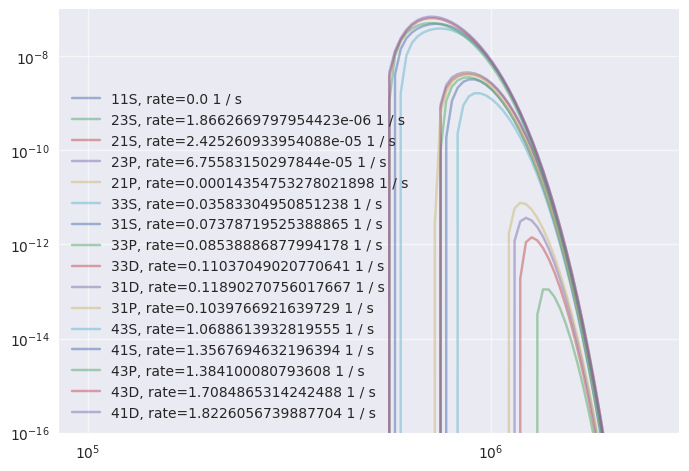

In [ ]:
states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 5))
v_range = np.geomspace(1e5, 2.5e6, 100) * u.m/u.s
for state in states.names:
    if state in sigma_params and state in ion_threshold:
        sigma = get_sigma(state, sigma_params, ion_threshold)
        integrand = lambda v: n_e * distibution(v) * v * sigma((1/2 * const.m_e * v**2).to("eV"))
        rate= np.trapz(integrand(v_range), v_range)
        plt.loglog(v_range, integrand(v_range), label=f"{state}, rate={rate.cgs}", alpha=0.5)

plt.ylim(1e-16, 1e-7)
plt.legend()
plt.show()

In [ ]:
import scipy.integrate
import pandas
def parse_electron_ionization_params():
    table = pandas.read_csv("atomic data/electron_ionization.csv", skiprows=6, skipfooter=5, engine="python", sep="\s+", header=None, index_col="i", names=["i", "A_1", "A_2", "A_3", "A_4", "A_5", "A_6"])
    return table.T.to_dict("list")
sigma_params = parse_electron_ionization_params()
ion_threshold = {name:(x[0][0] * u.Ry).to(u.eV) for name,x in NLTE.NLTE_model.get_ionization_dict().items()}

T = 4400 * u.K
n_e = 2.8e7 * u.cm**-3
def get_sigma(statename, sigma_params, ion_threshold):
    A = sigma_params[statename] * u.cm**2
    I = ion_threshold[statename]
    exponents = np.arange(1,6)
    def sigma(E):
        parenthesis = 1-I/E
        return np.where(E > I, 1e-13 * u.eV**2/(I*E)*(A[0] * np.log(E/I) + sum([A[i] * parenthesis**i for i in exponents])), 0 * u.cm**2)
    return sigma # sum(A[1:] * (1-I/E)**np.arange(1,6)))
sigma = get_sigma("23S", sigma_params, ion_threshold)
distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
def quad_wrapper(func, a, b, **kwargs):
    in_unit = a.unit
    out_unit = func(a).unit
    return scipy.integrate.quad(lambda x: func(x*in_unit).to(out_unit).value, a.to(in_unit).value, b.to(in_unit).value, **kwargs, epsabs=1e-20) * out_unit * in_unit
integrand = lambda v: n_e * distibution(v) * v * sigma((1/2 * const.m_e * v**2).to("eV"))
rate = quad_wrapper(integrand, 1e5 * u.m/u.s, 1e9 * u.m/u.s)[0].si
rate

In [ ]:
u.Ry

Unit("Ry")

11S -> 23S: Ralchenko:1.79e-23, Kington: 1.79e-23, ratio: 0.9975
11S -> 21S: Ralchenko:1.33e-24, Kington: 1.06e-24, ratio: 1.258
11S -> 23P: Ralchenko:2.03e-25, Kington: 2.13e-25, ratio: 0.9509
11S -> 21P: Ralchenko:5.13e-26, Kington: 6.57e-26, ratio: 0.7811
11S -> 33S: Ralchenko:2.36e-27, Kington: 2.43e-27, ratio: 0.9723
11S -> 31S: Ralchenko:5.98e-28, Kington: 7.20e-28, ratio: 0.8308
11S -> 33P: Ralchenko:3.80e-28, Kington: 4.25e-28, ratio: 0.8944
11S -> 33D: Ralchenko:6.72e-29, Kington: 1.15e-28, ratio: 0.5854
11S -> 31D: Ralchenko:2.15e-28, Kington: 2.68e-28, ratio: 0.8012
11S -> 31P: Ralchenko:9.20e-29, Kington: 1.02e-28, ratio: 0.9065
11S -> 43S: Ralchenko:7.40e-29, Kington: 1.32e-26, ratio: 0.005609
11S -> 41S: Ralchenko:2.55e-29, Kington: 1.07e-26, ratio: 0.00238
11S -> 43P: Ralchenko:2.32e-29, Kington: 9.77e-27, ratio: 0.002378
11S -> 43D: Ralchenko:7.52e-30, Kington: 9.07e-27, ratio: 0.000829
11S -> 41D: Ralchenko:1.54e-29, Kington: 9.07e-27, ratio: 0.001701
11S -> 43F: Ralch

/tmp/ipykernel_355250/3496049634.py:53: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{states.all_names[i]} -> {states.all_names[f]}: Ralchenko:{rate_matrix[f, i]:.2e}, Kington: {mat[f, i]:.2e}, ratio: {rate_matrix[f, i]/mat[f, i]:.4}")
/tmp/ipykernel_355250/3496049634.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"{states.all_names[i]} -> {states.all_names[f]}: Ralchenko:{rate_matrix[f, i]:.2e}, Kington: {mat[f, i]:.2e}, ratio: {rate_matrix[f, i]/mat[f, i]:.4}")
/tmp/ipykernel_355250/3496049634.py:55: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")
/tmp/ipykernel_355250/3496049634.py:55: RuntimeWarning: invalid value encountered in divide
  plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")


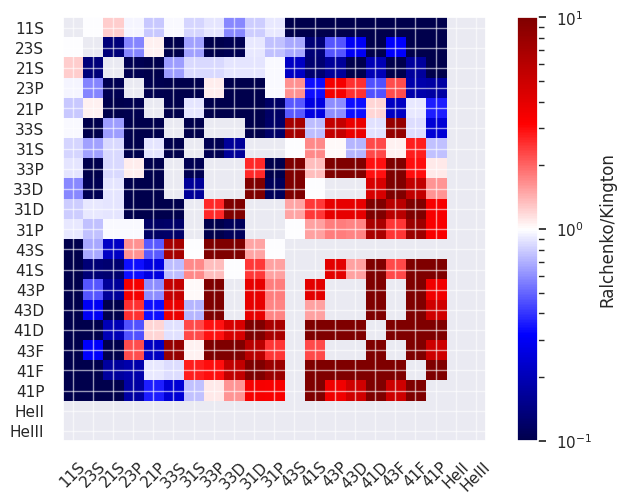

In [ ]:
import functools
# use seaborn style
import seaborn as sns
sns.set_theme()

all_states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 4))
get_E = lambda name: all_states.energies[all_states.names.index(name)]
get_g = lambda name: all_states.multiplicities[all_states.names.index(name)]

def get_cross_sections(filename, fit_function):
    table = pandas.read_csv(filename, skiprows=6, skipfooter=5, engine="python", sep="\s+", index_col=[0,1], header=None, skip_blank_lines=True)
    clamped_fit_function = lambda E, A, i, f: np.where(E>get_E(f) - get_E(i), fit_function(E/(get_E(f) - get_E(i)), A), 0) * np.pi * const.a0**2 * u.Ry / (get_g(i) * E)
    return {(i,f): functools.partial(clamped_fit_function, A=A, i = i, f=f) for (i,f), A in table.T.to_dict("list").items()}

sigmas = get_cross_sections("atomic data/dipole-allowed.csv",    lambda x, A: (A[0]*np.log(x) + A[1] + A[2]/x + A[3]/x**2 + A[4]/x**3)*(x+1)/(x+A[5]))\
       | get_cross_sections("atomic data/dipole-forbidden.csv", lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(x**2)/(x**2+A[4]))\
       | get_cross_sections("atomic data/spin-forbidden.csv",   lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(1)/(x**2+A[4]))

electron_v_distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
def quad_wrapper(func, a, b, **kwargs):
    in_unit = a.unit
    out_unit = func(a, *kwargs.get("args", tuple())).unit
    f = lambda x, *args: func(x*in_unit, *args).to(out_unit).value
    return scipy.integrate.quad(f, a.to(in_unit).value, b.to(in_unit).value, **kwargs, epsabs=1e-20) * out_unit * in_unit

v_to_E = lambda v: 1/2 * const.m_e * v**2
n_e = 1.07e8 * u.cm**-3
T = 4400 * u.K
integrand = lambda v, sigma: n_e * electron_v_distibution(v) * v * sigma(v_to_E(v))

E_range = np.geomspace(1e-7, 1e5, 10000) * u.eV
v_range = np.sqrt(2*E_range/const.m_e)
index = all_states.names
rate_matrix = np.zeros((len(all_states.all_names), len(all_states.all_names)))
for (i,f), sigma in sigmas.items(): 
    if i not in all_states.names or f not in all_states.names:
        continue
    # these are excitations, so i is the lower state and f is the upper state
    # rate_matrix[i,f] on the other hand is the rate from f to i
    i_index = all_states.names.index(i)
    f_index = all_states.names.index(f)
    rate = np.trapz(integrand(v_range, sigma), v_range).to(1/u.s).value
    rate_matrix[f_index, i_index] = rate
    # Calculate the deexcitation rate from f to i
    # Easier to come down if lower multiplicity is lower, and if the energy difference greater
    w_ratio =  get_g(i) / get_g(f)
    delta_E = get_E(f) - get_E(i)
    rate_matrix[i_index, f_index] = rate * w_ratio * np.exp(delta_E/(const.k_B* T))

mat = nlte_solver.processes[0].get_transition_rate_matrix()
for i, f in itertools.product(range(10), range(21)):
    if i != f:
        print(f"{states.all_names[i]} -> {states.all_names[f]}: Ralchenko:{rate_matrix[f, i]:.2e}, Kington: {mat[f, i]:.2e}, ratio: {rate_matrix[f, i]/mat[f, i]:.4}")
# plot with log color scale
plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")
plt.colorbar(label="Ralchenko/Kington")
#plt.contour(rate_matrix/mat, levels=[1], colors="black")
plt.xticks(range(len(states.all_names)), states.all_names, rotation=45)
plt.yticks(range(len(states.all_names)), states.all_names);

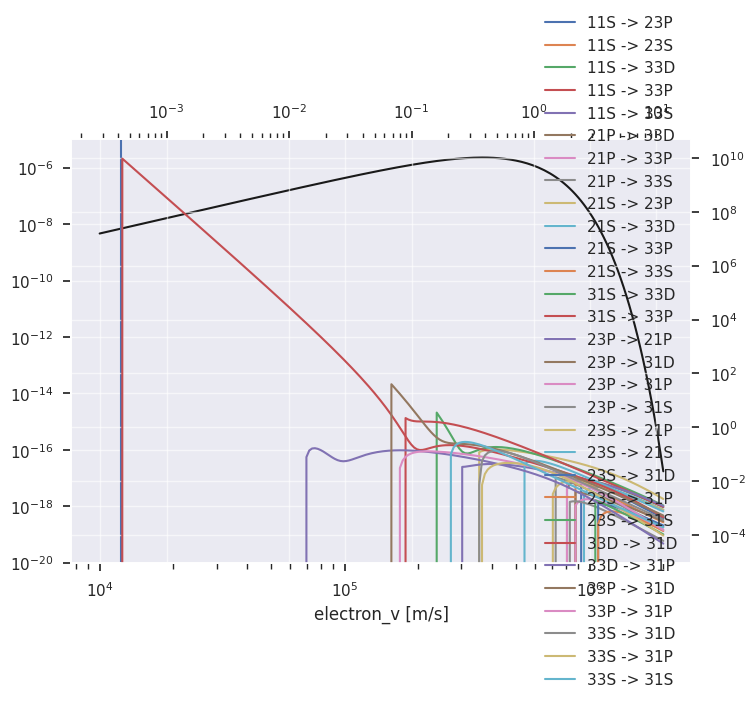

In [ ]:
T = 4400 * u.K
electron_v_distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
v_range = np.geomspace(1e4, 2e6, 200) * u.m/u.s
v_to_E = lambda v: 1/2 * const.m_e * v**2

plt.loglog(v_range, electron_v_distibution(v_range).si, color="k")
delta_E = np.abs(get_E("33D") - get_E("31D"))
v = np.sqrt(2*delta_E/const.m_e)
plt.axvline(v.si.value)
plt.ylim(1e-20,1e-5)
plt.xlabel("electron_v [m/s]")
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xscale("log")
ax2.set_xlim(*(v_to_E(np.array(ax1.get_xlim())*u.m/u.s)).to("eV").value)
ax3 = ax1.twinx()
for (i,f), sigma in sigmas.items(): 
    if (i[1] == "3") != (f[1] == "3") and i[0] in "123"  and f[0] in "123":
        ax3.loglog(v_range, sigma(v_to_E(v_range)), label=f"{i} -> {f}")
plt.legend(loc="right")

In [ ]:
get_E("33D") - get_E("31D")

<Quantity -0.00042409 eV>

In [ ]:
table = pandas.read_csv("atomic data/dipole-allowed.csv", skiprows=6, skipfooter=5, engine="python", sep="\s+", index_col=[0,1], header=None, skip_blank_lines=True)
all_states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 4))

for (i, f), A in table.T.to_dict("list").items():
    deltaE = all_states.energies[all_states.names.index(f)] - all_states.energies[all_states.names.index(i)] 
    g_l = all_states.multiplicities[all_states.names.index(i)]
    print(i, f, g_l, deltaE)


11S 21P 1 21.2180227112 eV
11S 31P 1 23.0870185296 eV
11S 41P 1 23.7420700688 eV
21S 21P 1 0.6022478882000009 eV
21S 31P 1 2.471243706600003 eV
21S 41P 1 3.1262952458000015 eV
21P 31S 3 1.7022946477999987 eV
21P 31D 3 1.8560520865699992 eV
21P 41S 3 2.455547878800001 eV
21P 41D 3 2.51831232416 eV
31S 31P 1 0.16670117060000322 eV
31S 41P 1 0.8217527098000019 eV
31D 31P 5 0.012943731830002747 eV
31D 41F 5 0.6629349243210001 eV
31D 41P 5 0.6679952710300014 eV
31P 41S 3 0.586552060399999 eV
31P 41D 3 0.6493165057599981 eV
41S 41P 1 0.06849947879999974 eV
41D 41F 5 0.000674686730999241 eV
41D 41P 5 0.005735033440000592 eV
23S 23P 3 1.144472364080002 eV
23S 33P 3 3.18745862071 eV
23S 43P 3 3.8882767029000007 eV
23P 33S 9 1.7543795299199978 eV
23P 33D 9 2.10956381946 eV
23P 43S 9 2.6298718239199985 eV
23P 43D 9 2.77200330102 eV
33S 33P 3 0.2886067267100003 eV
33S 43P 3 0.9894248089000008 eV
33P 33D 9 0.06657756283000182 eV
33P 43S 9 0.5868855672900004 eV
33P 43D 9 0.7290170443900017 eV
33D 43